# 転移学習 

Kaggleの[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)から`dogs-vs-cats-redux-kernels-edition.zip`をダウンロードし、VGG16で転移学習を行います。

読み込んだモデルの最後の出力だけを2に変更し、モデルパラメータは出力層(fc)のみを渡して学習を行います。

## データのロード

- dogs-vs-cats-redux-kernels-edition.zipを./data/dogs-vs-cats-redux-kernels-edition内に解凍
- ./data/dogs-vs-cats-redux-kernels-edition内のtrain.zipとtest.zipをその場で解凍


In [1]:
# zipファイルの解凍
import os
import zipfile

dogs_cats_dir = './data/dogs-vs-cats-redux-kernels-edition/'

# フォルダ'./data/dogs-vs-cats-redux-kernels-edition.zip'が存在しない場合にzipの解凍
if not os.path.exists(dogs_cats_dir):
    # dogs-vs-cats-redux-kernels-edition.zipを解凍
    with zipfile.ZipFile('./data/dogs-vs-cats-redux-kernels-edition.zip','r') as file:
        # /dogs-vs-cats-redux-kernels-editionディレクトリを作りその中に解凍ファイルを作製
        file.extractall(dogs_cats_dir)

# フォルダ'./data/dogs-vs-cats-redux-kernels-edition/'内にtestディレクトリが存在しない場合、
# 訓練データとテストデータのzipを解凍
if not os.path.exists(dogs_cats_dir+'test/'):
    # 訓練データとテストデータのzipを解凍
    for f in ['train.zip', 'test.zip']:
        with zipfile.ZipFile(dogs_cats_dir + f,'r') as file:
            file.extractall(dogs_cats_dir)

In [2]:
# 解凍したデータフォルダの構造を確認する
!ls ./data/dogs-vs-cats-redux-kernels-edition/

logs  sample_submission.csv  test  test.zip  train  train.zip  valid


In [3]:
from glob import glob

# 全ての.jpgファイルパスのリストを取得
g_train = glob('./data/dogs-vs-cats-redux-kernels-edition/train/*.jpg')
g_test = glob('./data/dogs-vs-cats-redux-kernels-edition/test/*.jpg')
# データ数の確認
print('train image size', len(g_train))
print('test image size', len(g_test))

train image size 0
test image size 0


### 訓練データの中からバリデーションデータを抽出

訓練データからランダムに選んだ2000枚をバリデーションデータとします。

In [4]:
import numpy as np

valid_path = './data/dogs-vs-cats-redux-kernels-edition/valid/'
# validディレクトリ
if not os.path.exists(valid_path):
    os.mkdir(valid_path)
    # ファイルパスをリストで取得
    g = glob('./data/dogs-vs-cats-redux-kernels-edition/train/*.jpg')
    
    # 訓練データからランダムに選んだ2000枚をバリデーションデータとします
    shuf = np.random.permutation(g)
    for i in range(2000):
        # ファイル名から./data/dogs-vs-cats-redux-kernels-edition/train/`の部分を取り除きファイル名にする
        # trainからvalidのディレクトリに画像ファイルを移動
        os.rename(shuf[i], os.path.join(valid_path, shuf[i][48:]))


In [5]:
# 全ての.jpgファイルパスのリストを取得
g_train = glob('./data/dogs-vs-cats-redux-kernels-edition/train/*.jpg')
g_valid = glob('./data/dogs-vs-cats-redux-kernels-edition/valid/*.jpg')
g_test = glob('./data/dogs-vs-cats-redux-kernels-edition/test/*.jpg')
# データ数の確認
print('train image size', len(g_train))
print('valid image size', len(g_valid))
print('test image size', len(g_test))

train image size 0
valid image size 0
test image size 0


### クラスごとにサブディレクトリを作成する

PyTorchで読み込みやすいようにクラスごとにサブディレクトリを作成します。<br>Kaggleのテストデータは正解ラベルがついていないため unknown というサブディレクトリに入れます。

最終的なデータの階層構造は

```
train
  cats
    cat.1.jpg
    cat.2.jpg
  dogs
    dog.1.jpg
    dog.2.jpg
valid
  cats
    cat.10.jpg
    cat.21.jpg
  dogs
    dog.8.jpg
    dog.52.jpg
test
  unknown
    1.jpg
    2.jpg
```

In [6]:
g_train[:2]

[]

In [7]:
# 訓練データ
# 全ての.jpgファイルパスのリストを取得
g_train_dog = glob('./data/dogs-vs-cats-redux-kernels-edition/train/dog*.jpg')
g_train_cat = glob('./data/dogs-vs-cats-redux-kernels-edition/train/cat*.jpg')

train_dog_path = './data/dogs-vs-cats-redux-kernels-edition/train/dog/'
train_cat_path = './data/dogs-vs-cats-redux-kernels-edition/train/cat/'

# dogディレクトリの処理
if not os.path.exists(train_dog_path):
    os.mkdir(train_dog_path)
    for g in range(len(g_train_dog)):
        # ファイル名から./data/dogs-vs-cats-redux-kernels-edition/train/`の部分を取り除きファイル名にする
        # trainからvalidのディレクトリに画像ファイルを移動
        os.rename(g_train_dog[g], os.path.join(train_dog_path, g_train_dog[g][48:]))
# catディレクトリの処理
if not os.path.exists(train_cat_path):
    os.mkdir(train_cat_path)
    for g in range(len(g_train_cat)):
        # ファイル名から./data/dogs-vs-cats-redux-kernels-edition/train/`の部分を取り除きファイル名にする
        # trainからvalidのディレクトリに画像ファイルを移動
        os.rename(g_train_cat[g], os.path.join(train_cat_path, g_train_cat[g][48:]))


In [8]:
# バリデーションデータ
# 全ての.jpgファイルパスのリストを取得
g_valid_dog = glob('./data/dogs-vs-cats-redux-kernels-edition/valid/dog*.jpg')
g_valid_cat = glob('./data/dogs-vs-cats-redux-kernels-edition/valid/cat*.jpg')

valid_dog_path = './data/dogs-vs-cats-redux-kernels-edition/valid/dog/'
valid_cat_path = './data/dogs-vs-cats-redux-kernels-edition/valid/cat/'

# dogディレクトリの処理
if not os.path.exists(valid_dog_path):
    os.mkdir(valid_dog_path)
    for g in range(len(g_valid_dog)):
        # ファイル名から./data/dogs-vs-cats-redux-kernels-edition/train/`の部分を取り除きファイル名にする
        # trainからvalidのディレクトリに画像ファイルを移動
        os.rename(g_valid_dog[g], os.path.join(valid_dog_path, g_valid_dog[g][48:]))
# catディレクトリの処理
if not os.path.exists(valid_cat_path):
    os.mkdir(valid_cat_path)
    for g in range(len(g_valid_cat)):
        # ファイル名から./data/dogs-vs-cats-redux-kernels-edition/train/`の部分を取り除きファイル名にする
        # trainからvalidのディレクトリに画像ファイルを移動
        os.rename(g_valid_cat[g], os.path.join(valid_cat_path, g_valid_cat[g][48:]))


In [9]:
# テストデータ
# 全ての.jpgファイルパスのリストを取得
g_test = glob('./data/dogs-vs-cats-redux-kernels-edition/test/*.jpg')

# テストデータにはラベルがないのでunknownディレクトリにデータを格納
test_unknown_path = './data/dogs-vs-cats-redux-kernels-edition/test/unknown'

# unknownディレクトリの処理
if not os.path.exists(test_unknown_path):
    os.mkdir(test_unknown_path)
    for g in range(len(g_test)):
        # ファイル名から./data/dogs-vs-cats-redux-kernels-edition/train/`の部分を取り除きファイル名にする
        # trainからvalidのディレクトリに画像ファイルを移動
        os.rename(g_test[g], os.path.join(test_unknown_path, g_test[g][48:]))


## データをテンソルに変換

学習時と評価・テスト時でデータの変換関数を変えます。
- 学習時は汎化性能が上がるように`RandomResizedCrop` や `RandomHorizontalFlip` などデータ拡張する変換を入れる
- 評価時はこのようなランダム性は入れずに入力画像のサイズがネットワークに合うようにサイズを変形する
- `Normalize()` はImageNetの訓練データの平均と分散を表し、入力画像を平均0、分散1に標準化する。

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

# デバイスモードの取得
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)    # デバイスモードの確認


# transform の定義
# ToTensor で Tensorに変換し
# 画像サイズを(224, 224)で統一
# 標準化 平均0、標準偏差1
# Resizeの前にtransforms.ToTensor()を入れるとエラーになるので注意
train_transform = transforms.Compose(
    [transforms.Resize((224, 224)),                                         # データを(224, 224)に統一する
#      transforms.RandomHorizontalFlip(),                                     # ランダムに左右を入れ替える
#      transforms.ColorJitter(),                                              # ランダムに画像の閾値を変える
#      transforms.RandomRotation(10),                                         # ランダムに画像の回転（±10°）
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 平均0、標準偏差1で標準化
    ]
)

test_transform = transforms.Compose(
    [transforms.Resize((224, 224)),                                         # データを(224, 224)に統一する
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 平均0、標準偏差1で標準化
    ]
)

cpu


In [11]:
# 画像データをデータセットに格納する
# 扱うデータが画像でクラスごとにフォルダ分けされているのでImageFolder()を使用
train_dir = './data/dogs-vs-cats-redux-kernels-edition/train/'
valid_dir = './data/dogs-vs-cats-redux-kernels-edition/valid/'
test_dir = './data/dogs-vs-cats-redux-kernels-edition/test/'

df_train = torchvision.datasets.ImageFolder(
    root = train_dir,
    transform=train_transform
)

df_valid = torchvision.datasets.ImageFolder(
    root = valid_dir,
    transform=test_transform
)

df_test = torchvision.datasets.ImageFolder(
    root = test_dir,
    transform=test_transform
)

# クラスラベルの表示
print(df_train.classes)
print(df_valid.classes)
print(df_test.classes)

['cat', 'dog']
['cat', 'dog']
['unknown']


cats がラベル0で dogs がラベル1になっていることがわかります。<br>おそらくアルファベット順にラベルが割り当てられたと<br>unknownはラベル0だけどこれはテスト時にしか使わないので問題なし。

## データローダーの作成

ミニバッチ単位でデータを取得するデータローダーを作成。<br>バッチサイズは128にし、訓練データだけシャッフルします。

In [12]:
from torch.utils.data import DataLoader, TensorDataset    # データ関連のユーティリティクラスのインポート

# 定数（学習方法の設計時）
BATCH_SIZE = 128        # バッチサイズ

# データローダー（loader）の作成 ミニバッチを扱うため、データローダー（loader）を作成する
train_loader = DataLoader(
    df_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)
valid_loader = DataLoader(
    df_valid,
    batch_size=BATCH_SIZE, 
    shuffle=False
)

## 作成したデータの確認（1バッチ分データを表示）

torch.Size([128, 3, 224, 224]) torch.Size([128])


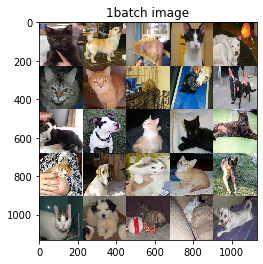

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(images, title=None):
    images = images.numpy().transpose((1, 2, 0))  # (h, w, c)
    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    if title is not None:
        plt.title(title)

images, classes = next(iter(loader_train))
print(images.size(), classes.size())
grid = torchvision.utils.make_grid(images[:25], nrow=5)
imshow(grid, title='1batch image')

## モデルの定義

#### モデルの読み込み


In [14]:
import torch.nn as nn

# 定数
INPUT_SIZE = 3    # 入力チャネル数（カラー画像なので、3を指定）
CONV2_CHANNELS = 16   # 出力チャネル数 16個のカーネルを作成（conv2の入力チャネルの数を一致させる必要があります[conv1の出力→活性化関数→プーリングを経てconv2の入力チャネルとして渡されます]）
INPUT_KERNELSIZE = 5  # 入力層のフィルター(カーネル) サイズ 5×5のサイズのカーネルを作成
PADDING_SIZE = 2      # パディングサイズ
OUTPUT_CHANNELS = 32  # 畳み込み層2の出力チャネル数
# 2×2のサイズでプーリングを行います(サイズ/2)
INPUT_POOLSIZE = (2, 2)    # プーリング層

FC_NEURONS = 7 * 7 * 32    # 隠れ層のニューロン数
OUTPUT_RESULTS = 2        # 出力層のニューロン数


# モデルの定義
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        # 継承したnn.Module親クラスを初期化
        super(ConvolutionalNeuralNetwork, self).__init__()
        
        # 層の定義
        self.layer1 = nn.Sequential(
            # 畳み込み層
            nn.Conv2d(
                INPUT_SIZE,           # 入力チャネル数
                CONV2_CHANNELS,       # 出力チャネル数
                kernel_size=INPUT_KERNELSIZE,      # 入力層のフィルター(カーネル) サイズ
                padding=PADDING_SIZE  # パディングサイズ
            ),
            nn.BatchNorm2d(CONV2_CHANNELS),  # 正則化
            nn.ReLU(),                       # 損失関数
            nn.MaxPool2d(INPUT_POOLSIZE),    # プーリング層（MaxPooling）
        )
        self.layer2 = nn.Sequential(
            # 畳み込み層
            nn.Conv2d(
                CONV2_CHANNELS,       # 入力チャネル数
                OUTPUT_CHANNELS,      # 出力チャネル数
                kernel_size=INPUT_KERNELSIZE,      # 入力層のフィルター(カーネル) サイズ
                padding=PADDING_SIZE  # パディングサイズ
            ),
            nn.BatchNorm2d(OUTPUT_CHANNELS), # 正則化
            nn.ReLU(),                       # 損失関数
            nn.MaxPool2d(INPUT_POOLSIZE),    # プーリング層（MaxPooling）
        )
        # 全結合層
        self.fc = nn.Linear(
            FC_NEURONS,       # 入力ユニット数
            OUTPUT_RESULTS    # 出力結果への出力ユニット数
        )
    def forward(self, x):
#         print('Input_size : ', x.size())    # 出力サイズの確認  debag
        x = self.layer1(x)
#         print('layer1_output_size : ', x.size())    # 出力サイズの確認  debag
        x = self.layer2(x)
#         print('layer2_output_size : ', x.size())    # 出力サイズの確認  debag
        x = x.view(x.size(0), -1)     # 畳み込み層の出力サイズを全結合層の入力ニューロン数に変換
#         print('fc_activation_output_size : ', x.size())    # 出力サイズの確認  debag
        x = self.fc(x)
#         print('Output_size : ', x.size())    # 出力サイズの確認  debag
        return x

# モデルのインスタンス化
model = ConvolutionalNeuralNetwork().to(device)
print(model)                      # モデルの概要を出力

ConvolutionalNeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=2, bias=True)
)


- CNNはブロック単位で処理（Conv+BN+ReLU+Pooling）できるようにまとめて Sequential を使います
- Conv2d や BatchNorm2d はKerasと違って入力と出力のユニットサイズを省略できません。
- サイズを自分で計算するのが面倒ならば、モデルの途中結果サイズを print(out.size()) で出力します。

In [15]:
# モデルの動作テスト
# image, label = iter(train_loader).next()
# print('before view : ', image.size())
# image = image.to(device)
# print()
# output = model(image)    # テストの実行
# print()
# print('after view : ', output.size())

## 層ごとの出力の算出

#### 畳み込み層とプーリング層の算出式+全結合層の入力

$
入力サイズ : [高さ, 幅]=[H, W]\\
出力サイズ : [高さ, 幅]=[O_h, O_w]\\
フィルタサイズのサイズ : [高さ, 幅]=[F_h, F_w]\\
パディングサイズ : P\\
ストライド : S\\
$
出力サイズ$O_h, O_w$は以下のように計算できます。
$$O_h=\frac{H+2P-F_h}{s}+1\\
O_w=\frac{W+2P-F_w}{s}+1$$


## 損失関数の定義<br>オプティマイザー（最適化用オブジェクト）の作成

In [16]:
import torch.optim as optim    # 最適化モジュールのインポート

# 定数
LEARN_RATE = 0.01        # 学習率
# 変数
criterion = nn.CrossEntropyLoss()   # 損失関数：交差エントロピー 学習データの正解率を出力
optimizer = optim.Adam(
        model.parameters(),   # 最適化で更新する重みやバイアスのパラメータ
        lr=LEARN_RATE,        # 学習率
)

## 1回分の「訓練（学習）」と「評価」の処理

In [21]:
def train_step(model, criterion, optimizer, train_loader):
    """学習の実行
    訓練モードの設定
    フォワードプロパゲーションで出力結果の取得
    出力結果と正解ラベルから損失および勾配の計算
    勾配を使ってパラメーター（重みとバイアス）の更新
    
    Param:
        model : 定義したモデル
        criterion : 損失関数
        optimizer : オプティマイザー
        train_loader : 訓練データのデータローダー
    """
    # 学習モードの設定
    model.train()
    # 学習中の損失を格納する変数
    running_loss = 0
    # 1ミニバッチ分の「訓練」を実行
    for batch_idx, (images, labels) in enumerate(train_loader):
        # デバイス情報をデータに送る
        images = images.to(device)
        labels = labels.to(device)
        # フォワードプロパゲーションで出力結果を取得
        outputs = model(images)
        
        # 出力結果と正解ラベルから損失を計算し、勾配を計算
        optimizer.zero_grad()    # 勾配を0で初期化

        loss = criterion(outputs, labels)    # 誤差（出力結果と正解ラベルの差）から損失を取得
        running_loss += loss.data[0]         # 損失をpythonの値で追加
        loss.backward()                      # 逆伝播の処理として勾配を計算（自動微分）

        # 勾配を使ってパラメーター（重みとバイアス）を更新
        optimizer.step()                     # 最適化の実施
    # 損失の算出ミニバッチ数分の損失の合計をミニバッチ数で割る
    train_loss = running_loss / len(train_loader)
    return train_loss

def valid_step(model, criterion, valid_loader):
    """評価（推論）検証
    評価モードの設定
    フォワードプロパゲーションで出力結果の取得
    出力結果と正解ラベルから損失の計算
    正解率の算出
    
    Param:
        model : 定義したモデル
        criterion : 損失関数
        optimizer : オプティマイザー
        valid_loader : 評価データのデータローダー
    """
    # 評価モードに設定（dropoutなどの挙動が評価用になる）
    model.eval()
    
    running_loss = 0    # 検証中の損失を格納する変数
    correct = 0         # 検証の正解数を格納する変数
    total = 0           # 1ミニバッチ数を格納する変数
    
    with torch.no_grad():                # 勾配は計算しないモードに設定
        # 1ミニバッチ分の「検証」を実行
        for batch_idx, (images, labels) in enumerate(valid_loader):
            # デバイス情報をデータに送る
            images = images.to(device)
            labels = labels.to(device)
            # フォワードプロパゲーションで出力結果を取得
            outputs = model(images)
            
            loss = criterion(outputs, labels)    # 誤差（出力結果と正解ラベルの差）から損失を取得
            running_loss += loss.item()          # 損失をpythonの値で追加
            _, predict = torch.max(outputs, 1)   # 予測した確率の最大値を予測結果として出力
            correct += (predict == labels).sum().item()  # 正解数を取得
            total += labels.size(0)              # 1ミニバッチ数の取得
            
    val_loss = running_loss / len(valid_loader)
    val_acc = float(correct) / total
    
    return val_loss, val_acc

In [22]:
log_dir = './data/dogs-vs-cats-redux-kernels-edition/logs/'
# logsディレクトリ
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

In [23]:
EPOCHS = 5    # エポック数
log_dir = './data/dogs-vs-cats-redux-kernels-edition/logs/'

best_acc = 0
loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(EPOCHS):
    loss = train_step(model, criterion, optimizer, train_loader)
    val_loss, val_acc = valid_step(model, criterion, valid_loader)

    # 損失や正解率などの情報を表示
    print(f'[Epoch {epoch+1:3d}/{EPOCHS:3d}]' \
          f' loss: {loss:.5f}' \
          f' val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    
    if val_acc > best_acc:
        print('val_acc improved from %.5f to %.5f!' % (best_acc, val_acc))
        best_acc = val_acc
        model_file = 'epoch%03d-%.3f-%.3f.pth' % (epoch, val_loss, val_acc)
        torch.save(model.state_dict(), os.path.join(log_dir, model_file))

    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
# 学習終了後、学習に要した時間を出力
print("Computation time:{0:.3f} sec".format(time.time() - start))

NameError: name 'train_loader' is not defined

## 損失値の推移グラフ描画


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot learning curve
plt.figure()
plt.plot(range(EPOCHS), loss_list, 'r-', label='train_loss')
plt.plot(range(EPOCHS), val_loss_list, 'b-', label='val_loss')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(EPOCHS), val_acc_list, 'g-', label='val_acc')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

## 予測結果の出力

In [ ]:
# 1データだけ取得
image, label = iter(test_loader).next()

# 評価モードに設定（dropoutなどの挙動が評価用になる）
model.eval()

running_loss = 0    # 検証中の損失を格納する変数
correct = 0         # 検証の正解数を格納する変数
total = 0           # 1ミニバッチ数を格納する変数

with torch.no_grad():                # 勾配は計算しないモードに設定
    # 1ミニバッチ分の「検証」を実行
    # デバイス情報をデータに送る
    image = image.to(device)
    label = label.to(device)
    # フォワードプロパゲーションで出力結果を取得
    outputs = model(image)

    loss = criterion(outputs, label)    # 誤差（出力結果と正解ラベルの差）から損失を取得
    running_loss += loss.item()          # 損失をpythonの値で追加
    _, predict = torch.max(outputs, 1)   # 予測した確率の最大値を予測結果として出力
    # numpy化して予測結果を表示
    print(predict.numpy())
    
    correct += (predict == label).sum().item()  # 正解数を取得
    total += label.size(0)              # 1ミニバッチ数の取得

val_loss = running_loss / len(label)
val_acc = float(correct) / total

# 損失や正解率などの情報を表示
print(f' val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')

## modelを保存する

In [ ]:
torch.save(model.state_dict(), 'DOGCAT_CNN_torch.pth')    # state_dictはモデルの構造だけ保存

## modelを読み込み再度予測を行う

In [ ]:
# モデルのパラメータのロード
param = torch.load('DOGCAT_CNN_torch.pth')

事前にモデルのインスタンス化が必要です。<br>（インスタンス化したモデルにロードしたパラメータを設定します）

In [ ]:
import torch.nn as nn

# 定数
INPUT_SIZE = X_train.shape[1]    # 入力層のニューロン数
CONV2_CHANNELS = 16   # 出力チャネル数 16個のカーネルを作成（conv2の入力チャネルの数を一致させる必要があります[conv1の出力→活性化関数→プーリングを経てconv2の入力チャネルとして渡されます]）
INPUT_KERNELSIZE = 5  # 入力層のフィルター(カーネル) サイズ 5×5のサイズのカーネルを作成
PADDING_SIZE = 2      # パディングサイズ
OUTPUT_CHANNELS = 32  # 畳み込み層2の出力チャネル数
# 2×2のサイズでプーリングを行います(サイズ/2)
INPUT_POOLSIZE = (2, 2)    # プーリング層

FC_NEURONS = 7 * 7 * 32    # 隠れ層のニューロン数
OUTPUT_RESULTS = 2        # 出力層のニューロン数


# モデルの定義
class pre_ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        # 継承したnn.Module親クラスを初期化
        super(ConvolutionalNeuralNetwork, self).__init__()
        
        # 層の定義
        self.layer1 = nn.Sequential(
            # 畳み込み層
            nn.Conv2d(
                INPUT_SIZE,           # 入力チャネル数
                CONV2_CHANNELS,       # 出力チャネル数
                kernel_size=INPUT_KERNELSIZE,      # 入力層のフィルター(カーネル) サイズ
                padding=PADDING_SIZE  # パディングサイズ
            ),
            nn.BatchNorm2d(CONV2_CHANNELS),  # 正則化
            nn.ReLU(),                       # 損失関数
            nn.MaxPool2d(INPUT_POOLSIZE),    # プーリング層（MaxPooling）
        )
        self.layer2 = nn.Sequential(
            # 畳み込み層
            nn.Conv2d(
                CONV2_CHANNELS,       # 入力チャネル数
                OUTPUT_CHANNELS,      # 出力チャネル数
                kernel_size=INPUT_KERNELSIZE,      # 入力層のフィルター(カーネル) サイズ
                padding=PADDING_SIZE  # パディングサイズ
            ),
            nn.BatchNorm2d(OUTPUT_CHANNELS), # 正則化
            nn.ReLU(),                       # 損失関数
            nn.MaxPool2d(INPUT_POOLSIZE),    # プーリング層（MaxPooling）
        )
        # 全結合層
        self.fc = nn.Linear(
            FC_NEURONS,       # 入力ユニット数
            OUTPUT_RESULTS    # 出力結果への出力ユニット数
        )
    def forward(self, x):
        # print('Input_size : ', x.size())    # 出力サイズの確認  debag
        x = self.layer1(x)
        # print('layer1_output_size : ', x.size())    # 出力サイズの確認  debag
        x = self.layer2(x)
        # print('layer2_output_size : ', x.size())    # 出力サイズの確認  debag
        x = x.view(x.size(0), -1)     # 畳み込み層の出力サイズを全結合層の入力ニューロン数に変換
        # print('fc_activation_output_size : ', x.size())    # 出力サイズの確認  debag
        x = self.fc(x)
        # print('Output_size : ', x.size())    # 出力サイズの確認  debag
        return x

In [ ]:
# モデルのインスタンス化
model = pre_ConvolutionalNeuralNetwork().to(device) #読み込む前にクラス宣言が必要
model.load_state_dict(param)

テストデータのDataLoaderを作成して最初の128枚の画像をロードする。

In [ ]:
test_loader = DataLoader(
    df_test,
    batch_size=128, 
    shuffle=False
)

In [ ]:
# 1データだけ取得
image, label = iter(test_loader).next()

# 評価モードに設定（dropoutなどの挙動が評価用になる）
model.eval()

running_loss = 0    # 検証中の損失を格納する変数
correct = 0         # 検証の正解数を格納する変数
total = 0           # 1ミニバッチ数を格納する変数

with torch.no_grad():                # 勾配は計算しないモードに設定
    # 1ミニバッチ分の「検証」を実行
    # デバイス情報をデータに送る
    image = image.to(device)
    label = label.to(device)
    # フォワードプロパゲーションで出力結果を取得
    outputs = model(image)

    loss = criterion(outputs, label)    # 誤差（出力結果と正解ラベルの差）から損失を取得
    running_loss += loss.item()          # 損失をpythonの値で追加
    _, predict = torch.max(outputs, 1)   # 予測した確率の最大値を予測結果として出力
    # numpy化して予測結果を表示
    print(predict.numpy())
    
    correct += (predict == label).sum().item()  # 正解数を取得
    total += label.size(0)              # 1ミニバッチ数の取得

val_loss = running_loss / len(label)
val_acc = float(correct) / total

# 損失や正解率などの情報を表示
print(f' val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')

In [ ]:
from torch.autograd import Variable

images, _ = iter(loader_test).next()
images = Variable(images, volatile=True)
print(images.size())

In [ ]:
imshow(torchvision.utils.make_grid(images.data[:25], nrow=5))

予測

In [ ]:
outputs = model(images)
_, predicted = outputs.data

predicted には0（ネコ）、1（イヌ）の予測ラベルが入っている